In [1]:
import colorednoise as cn
from matplotlib import mlab
from matplotlib import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec


from scipy import signal
import scipy.stats as st
from scipy.signal import correlate, correlation_lags, detrend, coherence, welch, find_peaks

from sklearn.metrics import r2_score

import numpy as np
import gzip        
import pickle    
import pandas as pd


In [2]:
def mesh_index_to_km(x):
    return (x / 900) * 110

def km_to_mesh_index(x):
    return (x / 110) * 900

def get_GL_index(gl_array):
    gl_array = np.array(gl_array).astype(int)
    for i in range(1, len(gl_array)):
        if gl_array[i-1] == 0 and gl_array[i] == 1:
            return i
    return None

## Loading Data

In [3]:
# variable = "NoiseRNG(5)_ClimateChange(0_05)"
runName = "Amin_Seed5"
NoiseAmp = "Amp=1.0"

#################################################################################################################################
# Main Path
noise_path = "/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Dicts_Noise_900mesh/AminOnly/Seed5_amin_out.gz"
with gzip.open(noise_path, 'rb') as f:
    DATA_dict = pickle.load(f)

# Reference Path
base_path = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_10_15__14_55_30.pkl.gz"
with gzip.open(base_path, 'rb') as f:
    DATA_dict_base = pickle.load(f)

#################################################################################################################################
NoiseData = np.loadtxt(
    "/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/CSVs_Noise_900mesh/aminOnly/amin_amax_timeseries_amp1.0_3000yrs_RNG(5)_amin.csv",
    delimiter=",",
    skiprows=1  
)

In [4]:
bed_dict = DATA_dict['bed_dict']
base_dict = DATA_dict['base_dict']
surf_dict = DATA_dict['surf_dict']
sed_dict = DATA_dict['sed_dict']
H_dict = DATA_dict['H_dict']
us_dict = DATA_dict['us_dict']
ub_dict = DATA_dict['ub_dict']
Hs_dict = DATA_dict['Hs_dict']
GL_dict = DATA_dict['GL_dict']
Qs_dict = DATA_dict['Qs_dict']
SMB_dict = DATA_dict['SMB_dict']
counter_dict = DATA_dict['counter_dict']
final_time = list(GL_dict)[-1]

timesteps_model = np.array(list(us_dict.keys()))
mesh_indices = np.arange(len(us_dict[timesteps_model[0]]))
data_matrix = np.array([us_dict[t] for t in timesteps_model])

threshold = 0.06  # meters, or whatever your model units are
gl_positions = []

for t in timesteps_model:
    us = np.array(us_dict[t])
    ub = np.array(ub_dict[t])
    
    # Find where |us - ub| < tol
    diff = np.abs(us - ub)
    equal_points = np.where(diff < threshold)[0]

    if len(equal_points) == 0:
        gl_positions.append(np.nan)
        continue

    valid_points = equal_points[equal_points >= 1]

    if len(valid_points) == 0:
        gl_positions.append(np.nan)
        continue

    gl_positions.append(valid_points[0])
    
GL_Noisy_km = mesh_index_to_km(np.array(gl_positions))

peaks, _   = find_peaks(GL_Noisy_km, prominence=1)
peaktimes = timesteps_model[peaks]

troughs, _ = find_peaks(-GL_Noisy_km, prominence=1, distance=50)
troughtimes = timesteps_model[troughs]


periods    = np.diff(np.array(timesteps_model)[peaks])
adv_dists  = GL_Noisy_km[peaks]
ret_dists  = GL_Noisy_km[troughs]

time_years = NoiseData[:,0]
noisy_amin_series = NoiseData[:,1]
noisy_amax_series = NoiseData[:,2]

dt_1 = np.mean(np.diff(time_years))
freqs_amin1, Pxx_amin1 = welch(noisy_amin_series, fs=1.0/dt_1, nperseg=min(256, len(noisy_amin_series)))
freqs_amax1, Pxx_amax1 = welch(noisy_amax_series, fs=1.0/dt_1, nperseg=min(256, len(noisy_amax_series)))

print(final_time)


3000.542636326571


In [5]:
bed_dictBase = DATA_dict_base['bed_dict']
base_dictBase = DATA_dict_base['base_dict']
surf_dictBase = DATA_dict_base['surf_dict']
sed_dictBase = DATA_dict_base['sed_dict']
H_dictBase = DATA_dict_base['H_dict']
us_dictBase = DATA_dict_base['us_dict']
ub_dictBase = DATA_dict_base['ub_dict']
Hs_dictBase = DATA_dict_base['Hs_dict']
GL_dictBase = DATA_dict_base['GL_dict']
Qs_dictBase = DATA_dict_base['Qs_dict']
SMB_dict = DATA_dict['SMB_dict']
counter_dictBase = DATA_dict_base['counter_dict']
final_timeBase = list(GL_dictBase)[-1]

# timeBase = list(GL_dictBase.keys())
# mesh_indicesBase = np.arange(len(GL_dictBase[timeBase[0]]))
# data_matrixBase = np.array([GL_dictBase[t] for t in timeBase])
# gl_positionsBase = [np.argmax(row > 0.5) for row in data_matrixBase]
# GL_kmBase = mesh_index_to_km(np.array(gl_positionsBase))

timeBase = np.array(list(us_dictBase.keys()))
mesh_indicesBase = np.arange(len(us_dictBase[timeBase[0]]))
data_matrixBase = np.array([us_dictBase[t] for t in timeBase])

threshold = 0.05  # meters, or whatever your model units are
gl_positionsBase = []

for t in timeBase:
    us = np.array(us_dictBase[t])
    ub = np.array(ub_dictBase[t])
    
    # Find where |us - ub| < tol
    diff = np.abs(us - ub)
    equal_points = np.where(diff < threshold)[0]

    if len(equal_points) == 0:
        gl_positionsBase.append(np.nan)
        continue

    # The grounding line = first point where they are equal moving downstream
    gl_positionsBase.append(equal_points[0])

GL_kmBase = mesh_index_to_km(np.array(gl_positionsBase))

peaksBase, _   = find_peaks(GL_kmBase, prominence=5)
troughsBase, _ = find_peaks(-GL_kmBase, prominence=5)

periodsBase    = np.diff(np.array(timeBase)[peaksBase])
adv_distsBase  = GL_kmBase[peaksBase]
ret_distsBase  = GL_kmBase[troughsBase]

# dt_Base = np.mean(np.diff(time_years))
# freqs_aminBase, Pxx_aminBase = welch(amin_seriesBase, fs=1.0/dt_Base, nperseg=min(256, len(amin_seriesBase)))
# freqs_amaxBase, Pxx_amaxBase = welch(amax_seriesBase, fs=1.0/dt_Base, nperseg=min(256, len(amax_seriesBase)))

print(final_timeBase)

3000.4073905925293


## GL Plot w/ Comparison to Amin and Amax over time

In [6]:
# Calculating running mean for amin and amax
mean_window = 101

# Calculate running mean 
series = pd.Series(noisy_amin_series, index=time_years)
rm_amin = series.rolling(window = mean_window, center = True, min_periods=1).mean()

series = pd.Series(noisy_amax_series, index=time_years)
rm_amax = series.rolling(window = mean_window, center = True, min_periods=1).mean()

# Calculate Slope of Running Mean
d_amin = np.gradient(rm_amin, time_years)
d_amax = np.gradient(rm_amax, time_years)

# Assign color based on increasing or decreasing slope of runnning mean
color_incAmin = 'firebrick'
color_decAmin = 'orangered'

color_incAmax = 'darkblue'
color_decAmax = 'dodgerblue'

def plot_colored_line(ax, x, y, dy, color_up, color_down, linewidth=1):
    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.asarray(dy)

    for i in range(len(x) - 1):
        c = color_up if dy[i] >= 0 else color_down
        ax.plot(x[i:i+2], y[i:i+2], color=c, lw=linewidth)

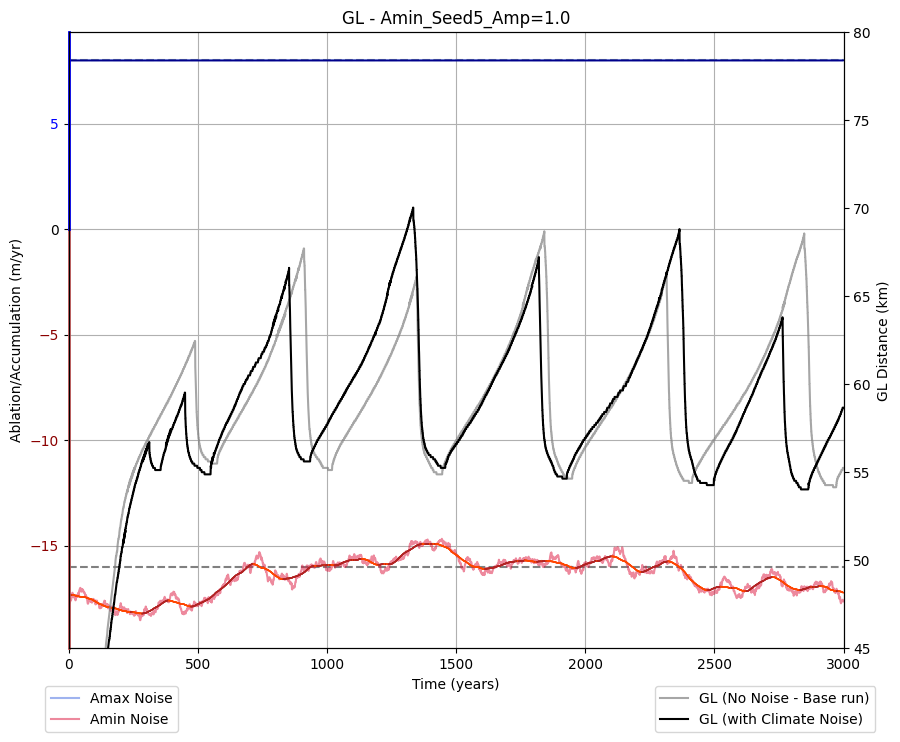

In [7]:
fig, ax = plt.subplots(figsize = (10,8))

# Base values of accumulation and ablation
ax.axhline(y=-16, linestyle = '--', color = 'grey')
ax.axhline(y=8, linestyle = '--', color = 'grey')

# Accumulation
ax.plot(time_years, noisy_amax_series, color = 'royalblue', alpha = 0.5, label = 'Amax Noise')
plot_colored_line(ax, time_years, rm_amax, d_amax, color_incAmax, color_decAmax)

# Ablation
ax.plot(time_years, noisy_amin_series, color = 'crimson', alpha = 0.5, label = 'Amin Noise')
plot_colored_line(ax, time_years, rm_amin, d_amin, color_incAmin, color_decAmin)


# GL position plotting
ax2 = ax.twinx()

ax2.plot(timeBase, GL_kmBase, color = 'gray', label = 'GL (No Noise - Base run)', alpha = 0.7)
ax2.plot(timesteps_model, GL_Noisy_km, color = 'black', label = 'GL (with Climate Noise)')

# Plot Settings
ax.set_xlabel("Time (years)")
ax.set_ylabel("Ablation/Accumulation (m/yr)")
ax2.set_ylabel("GL Distance (km)")
plt.title(f"GL - {runName}_{NoiseAmp}")

ax.set_xlim(0,3000)
ax2.set_ylim(45,80)

ax.grid()
ax.legend(bbox_to_anchor=(.15, -0.05))
ax2.legend(bbox_to_anchor=(1.05, -0.05))

# Coloring the Axis 
fig.canvas.draw()
yticks = ax.get_yticks()
ymin, ymax = ax.get_ylim()
xpos = ax.get_xlim()[0]

ax.axvline(x=xpos, ymin=0, ymax=(0 - ymin)/(ymax - ymin), color='indianred', lw=2, clip_on=False)
ax.axvline(x=xpos, ymin=(0 - ymin)/(ymax - ymin), ymax=1, color='blue', lw=2, clip_on=False)

for tick, val in zip(ax.get_yticklabels(), yticks):
    if val > 0:
        tick.set_color('blue')
    elif val < 0:
        tick.set_color('darkred')
    else:
        tick.set_color('black')

plt.show()


In [8]:
# fig, ax = plt.subplots(figsize = (8,5))

# # Grounding Line 
# ax.plot(time, GL_km, color = 'black', label = 'GL (with Climate Noise)')
# ax.plot(timeBase, GL_kmBase, color = 'gray', label = 'GL (No Noise - Base run)', alpha = 0.7)

# ax2 = ax.twinx()

# # Noisy Accumulation and Abaltion 
# ax2.plot(time_years, amax_series1, label = 'Accumulation (max)', color = 'blue')
# ax2.plot(time_years, amin_series1, label = 'Ablation (max)', color = 'red')

# # Base Accumulation and Ablation that noise is added to 
# # ax2.plot(time_years, amax_base, label = 'Accumulation (base)', color = 'blue', linestyle = '--')
# # ax2.plot(time_years, amin_base, label = 'Ablation (base)', color = 'red', linestyle = '--')


# ax.legend(bbox_to_anchor=(1.1, -0.05))
# ax2.legend(bbox_to_anchor=(.21, -0.05))

# ax.set_xlim(0,3000)
# ax.set_ylim(30,80)
# # ax2.set_ylim(-25,20)

# ax.set_xlabel("Time (years)")
# ax.set_ylabel("Distance (km)")
# ax2.set_ylabel("Ablation/Accumulation (m/yr)")

# plt.title(f"GL - {variable}_{value}")
# ax.grid()
# plt.show()

## Stats for Current Run - Range, Mean, Standard Deviation

In [9]:
print("*"*60)
print(f"STATS FOR TEST: {runName} {NoiseAmp}")
print("*"*60)

print("\n" + "="*60)
print("AMIN STATS")
print("="*60)

print(f"Amin (MAX) = {min(noisy_amin_series)}")
print(f"Amin (MIN) = {max(noisy_amin_series)}")
print("")
print(f"Amin (MEAN) = {np.mean(noisy_amin_series)}")
print(f"Amin (STDEV) = {np.std(noisy_amin_series)}")

print("\n" + "="*60)
print("AMAX STATS")
print("="*60)

print(f"Amax (MAX) = {max(noisy_amax_series)}")
print(f"Amax (MIN) = {min(noisy_amax_series)}")
print("")
print(f"Amax (MEAN) = {np.mean(noisy_amax_series)}")
print(f"Amax (STDEV) = {np.std(noisy_amax_series)}")

************************************************************
STATS FOR TEST: Amin_Seed5 Amp=1.0
************************************************************

AMIN STATS
Amin (MAX) = -18.525744
Amin (MIN) = -14.670863

Amin (MEAN) = -16.441410416944628
Amin (STDEV) = 0.8832842194269929

AMAX STATS
Amax (MAX) = 8.0
Amax (MIN) = 8.0

Amax (MEAN) = 8.0
Amax (STDEV) = 0.0


## Stats for Current Run - Correlation of Direct Results and Anomalies

In [10]:
# Direct comparison of Amin/Amax to GL 
print("\n" + "="*60)
print("Direct comparison of Amax to GL ")
print("="*60)

# interpolating values onto timescales
gl_noisy_interp_yrs = np.interp(time_years, timesteps_model, GL_Noisy_km)                   # GL interpolated onto yearly timesteps (Noise time)
gl_base_interp_yrs = np.interp(time_years, timeBase, GL_kmBase)                             # BASE GL interpolated onto yearly timesteps (Noise time)


r = np.corrcoef(noisy_amax_series, gl_noisy_interp_yrs)[0,1]
print(f"Direct Correlation Between Amax Noise & GL Position (r):    {r:.4f}")
r2 = r**2
print(f"The GL Position explained by Amax Noise (r2):               {r2:.4f} or {(r2*100):.4f}%")
pearsons_corrcoef, p_corr = st.pearsonr(noisy_amax_series,gl_noisy_interp_yrs)
print(f"P-value of                                                  {(p_corr)}")

print("\n" + "="*60)
print("Direct comparison of Amin to GL ")
print("="*60)


r = np.corrcoef(noisy_amin_series, gl_noisy_interp_yrs)[0,1]
print(f"Direct Correlation Between Amin Noise & GL Position (r):    {r:.4f}")
r2 = r**2
print(f"The GL Position explained by Amin Noise (r2):               {r2:.4f} or {(r2*100):.4f}%")
pearsons_corrcoef, p_corr = st.pearsonr(noisy_amin_series,gl_noisy_interp_yrs)
print(f"P-value of                                                  {(p_corr)}")

print("*"*100)

# Comparison of Amin/Amax Noise Anomaly to GL Anomaly
GL_resid = gl_noisy_interp_yrs - gl_base_interp_yrs       # Residual of GL (Noisy - Base )

amax_noise_resid = noisy_amax_series - 8


print("\n" + "="*60)
print("Comparison of Amax Noise Anomaly to GL Anomaly")
print("="*60)
r = np.corrcoef(amax_noise_resid, GL_resid)[0,1]
print(f"Correlation Between Amax Noise Anomaly & GL Position Anomaly (r):    {r:.4f}")
r2 = r**2
print(f"The GL Position Anomaly explained by Amax Noise Anomaly (r2):        {r2:.4f} or {(r2*100):.4f}%")
pearsons_corrcoef, p_corr = st.pearsonr(amax_noise_resid,GL_resid)
print(f"P-value of                                                           {(p_corr)}")


amin_noise_resid = noisy_amin_series + 16 

print("\n" + "="*60)
print("Comparison of Amin Noise Anomaly to GL Anomaly")
print("="*60)
r = np.corrcoef(amin_noise_resid, GL_resid)[0,1]
print(f"Correlation Between Amin Noise Anomaly & GL Position Anomaly (r):   {r:.4f}")
r2 = r**2
print(f"The GL Position Anomaly explained by Amin Noise Anomaly (r2):       {r2:.4f} or {(r2*100):.4f}%")
pearsons_corrcoef, p_corr = st.pearsonr(amin_noise_resid,GL_resid)
print(f"P-value of                                                          {(p_corr)}")

print("\n"+"*"*100)



Direct comparison of Amax to GL 
Direct Correlation Between Amax Noise & GL Position (r):    nan
The GL Position explained by Amax Noise (r2):               nan or nan%
P-value of                                                  nan

Direct comparison of Amin to GL 
Direct Correlation Between Amin Noise & GL Position (r):    0.5165
The GL Position explained by Amin Noise (r2):               0.2668 or 26.6818%
P-value of                                                  3.443252737524676e-204
****************************************************************************************************

Comparison of Amax Noise Anomaly to GL Anomaly
Correlation Between Amax Noise Anomaly & GL Position Anomaly (r):    nan
The GL Position Anomaly explained by Amax Noise Anomaly (r2):        nan or nan%
P-value of                                                           nan

Comparison of Amin Noise Anomaly to GL Anomaly
Correlation Between Amin Noise Anomaly & GL Position Anomaly (r):   0.2883
The 

/home/kayatroyer/anaconda3/envs/thesis_analysis/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kayatroyer/anaconda3/envs/thesis_analysis/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_579423/3854362846.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons_corrcoef, p_corr = st.pearsonr(noisy_amax_series,gl_noisy_interp_yrs)
/tmp/ipykernel_579423/3854362846.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons_corrcoef, p_corr = st.pearsonr(amax_noise_resid,GL_resid)


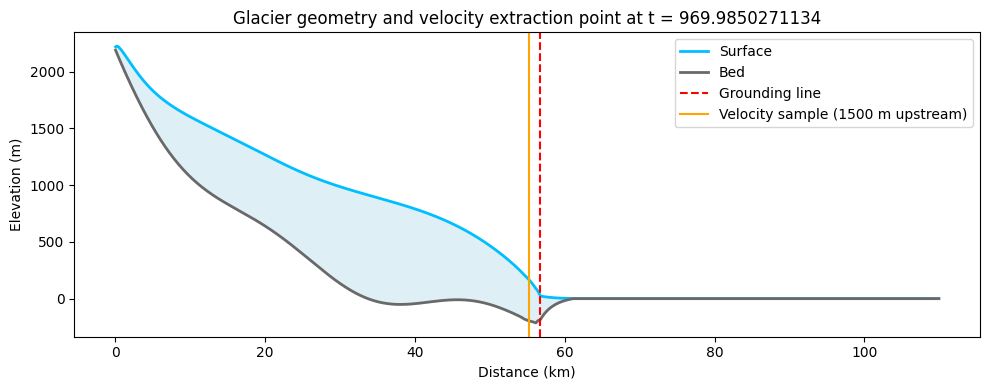

In [11]:
t_plot = sorted(us_dict.keys())[1500]  # choose by index or actual time
surf = surf_dict[t_plot]
base = base_dict[t_plot]
gl_array = GL_dict[t_plot]
us = us_dict[t_plot]

domain_length_m = 110e3
ncells = 900
dx = domain_length_m / ncells
x_cells = np.linspace(dx/2, domain_length_m - dx/2, ncells)
offset_m = 1500
offset_cells = int(round(offset_m / dx))

gl_index = get_GL_index(gl_array)
target_index = max(gl_index - offset_cells, 0)

# --- Plot glacier geometry ---
plt.figure(figsize=(10, 4))
plt.plot(x_cells / 1000, surf, label='Surface', color='deepskyblue', linewidth=2)
plt.plot(x_cells / 1000, base, label='Bed', color='dimgray', linewidth=2)

# Grounding line position
plt.axvline(x_cells[gl_index] / 1000, color='r', linestyle='--', label='Grounding line')

# Velocity extraction position 
plt.axvline(x_cells[target_index] / 1000, color='orange', linestyle='-', label=f'Velocity sample ({offset_m} m upstream)')

plt.fill_between(x_cells / 1000, base, surf, color='lightblue', alpha=0.4)
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.title(f'Glacier geometry and velocity extraction point at t = {t_plot}')
plt.legend()
plt.tight_layout()
plt.show()


# Velocity

In [12]:
domain_length_km = 110
num_cells = 900
dx_km = domain_length_km / num_cells
dx_m = dx_km * 1000  # 122 m per cell

offset_m = 1500
offset_cells = int(round(offset_m / dx_m))

# Extracting velocities for Noisy run
term_surface_velocity = []
term_basal_velocity = []

for t in sorted(us_dict.keys()): 
    us_ = us_dict[t]
    ub_ = ub_dict[t]
    gl_array = GL_dict[t]

    gl_index = get_GL_index(gl_array)

    if gl_index is not None and gl_index >= offset_cells:
        target_index = gl_index - offset_cells
        term_usvel = us_[target_index]
        term_ubvel = ub_[target_index]
    else:
        term_usvel = 0
        term_ubvel = 0

    if np.isnan(term_usvel):
        term_usvel = 0
    if np.isnan(term_ubvel):
        term_ubvel = 0

    term_surface_velocity.append(term_usvel)
    term_basal_velocity.append(term_ubvel)

# Extracting velocities for Base run
term_surface_velocity_base = []
term_basal_velocity_base = []

for t in sorted(us_dictBase.keys()): 
    us_base = us_dictBase[t]
    ub_base = ub_dictBase[t]
    gl_array_base = GL_dictBase[t]

    gl_index = get_GL_index(gl_array_base)

    if gl_index is not None and gl_index >= offset_cells:
        target_index = gl_index - offset_cells
        term_usvel_base = us_base[target_index]
        term_ubvel_base = ub_base[target_index]
    else:
        term_usvel_base = 0
        term_ubvel_base = 0

    if np.isnan(term_usvel_base):
        term_usvel_base = 0
    if np.isnan(term_ubvel_base):
        term_ubvel_base = 0

    term_surface_velocity_base.append(term_usvel_base)
    term_basal_velocity_base.append(term_ubvel_base)


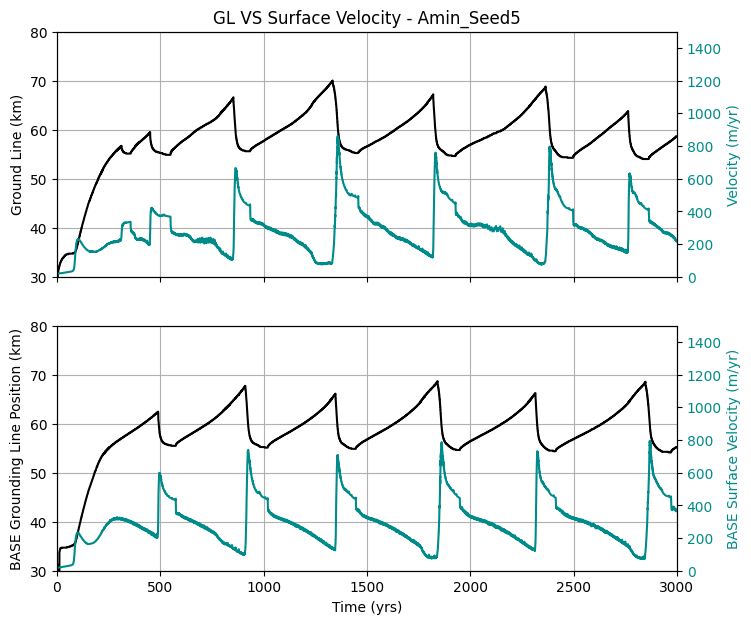

In [13]:
fig,ax = plt.subplots(nrows = 2, sharex = True, figsize = (8,7))

# GL position
ax[0].plot(timesteps_model, GL_Noisy_km, label='Grounding Line Position', color='black')
ax[0].set_ylabel("Ground Line (km)", color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].grid()

# Velocity
ax2 = ax[0].twinx()
ax2.plot(timesteps_model, term_surface_velocity, 'darkcyan', ls = '-', label='Surface Velocity (km/yr)')
ax2.set_ylabel("Velocity (m/yr)", color='darkcyan')
ax2.tick_params(axis='y', labelcolor='darkcyan')

ax[0].set_xlim(0,3000)
ax[0].set_ylim(30,80)
ax2.set_ylim(0,1500)

ax[0].set_title(f"GL VS Surface Velocity - {runName}")

# Base GL position
ax[1].plot(timeBase, GL_kmBase, color='black')
ax[1].set_xlabel("Time (yrs)")
ax[1].set_ylabel("BASE Grounding Line Position (km)", color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].grid()
ax[1].set_ylim(30,80)

# Base Velocity
ax2 = ax[1].twinx()
ax2.plot(timeBase, term_surface_velocity_base, 'darkcyan', ls = '-')
ax2.set_ylabel("BASE Surface Velocity (m/yr)", color='darkcyan')
ax2.tick_params(axis='y', labelcolor='darkcyan')
ax2.set_ylim(0,1500)

plt.show()
# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_Vel_{runName}_update.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_Vel_{runName}_update.png", format ="png", bbox_inches='tight')



# Thickness

In [14]:
# Extracting velocities for Noisy run
time_steps = sorted(H_dict.keys())
term_thickness = []


for t in time_steps:
    H_ = H_dict[t]
    gl_array = GL_dict[t]
    gl_index = get_GL_index(gl_array)

    if gl_index is not None and gl_index >= offset_cells:
        target_index = gl_index - offset_cells
        term_H = H_[target_index]
    else:
        term_H = np.nan

    term_thickness.append(term_H)

# Extracting velocities for Base run
time_steps_base = sorted(H_dictBase.keys())
term_thickness_base = []


for t in time_steps_base:
    H_ = H_dictBase[t]
    gl_array = GL_dictBase[t]
    gl_index = get_GL_index(gl_array)

    if gl_index is not None and gl_index >= offset_cells:
        target_index = gl_index - offset_cells
        term_H = H_[target_index]
    else:
        term_H = np.nan

    term_thickness_base.append(term_H)

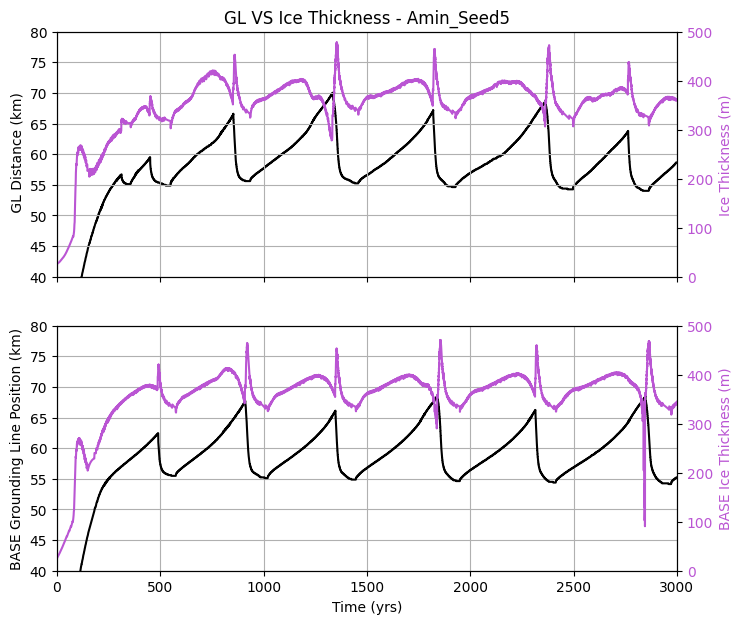

In [15]:
fig,ax = plt.subplots(nrows = 2, sharex = True, figsize = (8,7))

# Noisy GL position
ax[0].plot(timesteps_model, GL_Noisy_km, label='Grounding Line Position', color='black', zorder=1)
ax[0].set_ylabel(f" GL Distance (km)", color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].set_xlim(0,2000)
ax[0].grid()

# Noisy Thickness
ax2 = ax[0].twinx()
ax2.plot(time_steps, term_thickness, color='mediumorchid', linestyle='-', label=f'Ice Thickness', zorder=1)
ax2.set_ylabel(("Ice Thickness (m)"), color='mediumorchid')
ax2.tick_params(axis='y', labelcolor='mediumorchid')

ax[0].set_xlim(0,3000)
ax[0].set_ylim(40,80)
ax2.set_ylim(0,500)

# Noisy GL position
ax[1].plot(timeBase, GL_kmBase, color='black')
ax[1].set_xlabel("Time (yrs)")
ax[1].set_ylabel("BASE Grounding Line Position (km)", color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].grid()
ax[1].set_ylim(30,80)

# Noisy Thickness
ax2 = ax[1].twinx()
ax2.plot(time_steps_base, term_thickness_base, color='mediumorchid', linestyle='-', label=f'Ice Thickness', zorder=1)
ax2.set_ylabel(("BASE Ice Thickness (m)"), color='mediumorchid')
ax2.tick_params(axis='y', labelcolor='mediumorchid')

ax[1].set_xlim(0,3000)
ax[1].set_ylim(40,80)
ax2.set_ylim(0,500)

ax[0].set_title(f"GL VS Ice Thickness - {runName}")
plt.show()

# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_THK_{runName}_update.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_THK_{runName}_update.png", format ="png", bbox_inches='tight')


# Sediment Flux

Text(0.5, 1.0, ' GL VS Mean Sed Discharge: Amin_Seed5')

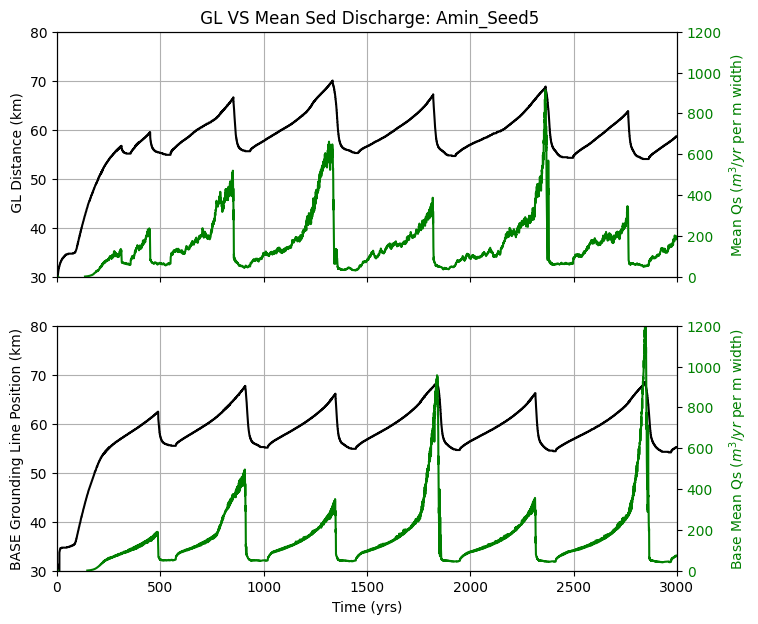

In [16]:
# Mean sediment discharge 
mean_Qs_filtered = np.array([
    np.mean([q for q in values if q > 1]) if any(q > 1 for q in values) else np.nan
    for values in Qs_dict.values()
])

timesteps_model = np.array(list(Qs_dict.keys()))

mean_Qs_base = np.array([np.mean(values) for values in Qs_dictBase.values()])
mean_Qs_filtered_base = np.array([
    np.mean([q for q in values if q > 1]) if any(q > 1 for q in values) else np.nan
    for values in Qs_dictBase.values()
])

timesteps_Qs_Base = np.array(list(Qs_dictBase.keys()))

fig,ax = plt.subplots(nrows = 2, sharex = True, figsize = (8,7))

# Noisy GL position
ax[0].plot(timesteps_model, GL_Noisy_km, label='Grounding Line Position', color='black')
ax[0].set_ylabel(f" GL Distance (km)", color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].grid()

# Noisy Sediment Discharge 
ax2 = ax[0].twinx()
ax2.plot(timesteps_model, mean_Qs_filtered, 'green', ls = '-')
ax2.set_ylabel("Mean Qs ($m^3/yr$ per m width)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax[0].set_xlim(0,3000)
ax[0].set_ylim(30,80)
ax2.set_ylim(0,1200)

# Base GL position
ax[1].plot(timeBase, GL_kmBase, color='black')
ax[1].set_xlabel("Time (yrs)")
ax[1].set_ylabel("BASE Grounding Line Position (km)", color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].grid()
ax[1].set_ylim(30,80)

# Base Sediment Discharge
ax2 = ax[1].twinx()
ax2.plot(timesteps_Qs_Base, mean_Qs_filtered_base, 'green', ls = '-')
ax2.set_ylabel("Base Mean Qs ($m^3/yr$ per m width)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax[0].set_xlim(0,3000)
ax[0].set_ylim(30,80)
ax2.set_ylim(0,1200)

ax[0].set_title(f" GL VS Mean Sed Discharge: {runName}")

# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_Qs_{runName}_update.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_Qs_{runName}_update.png", format ="png", bbox_inches='tight')


Text(0.5, 1.0, ' GL VS MAX Sed Discharge: Amin_Seed5')

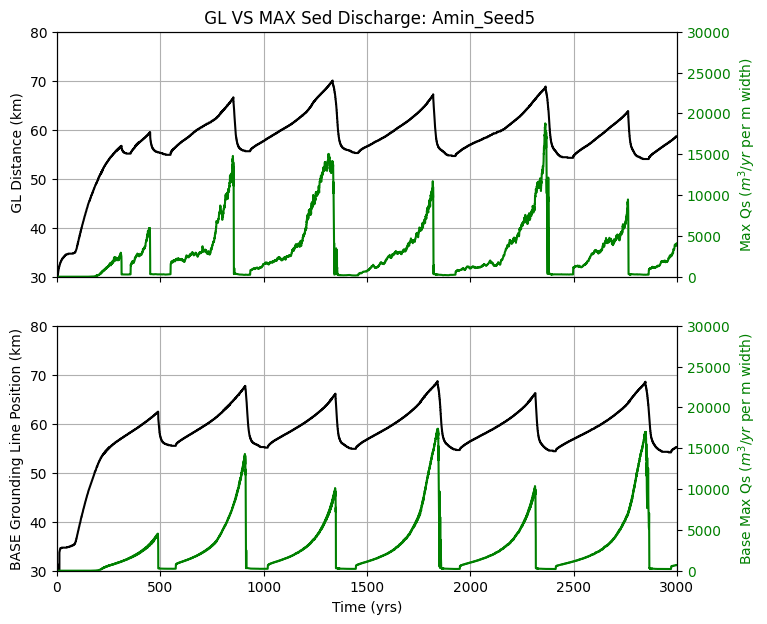

In [17]:
# Maximum Sediment Discharge
max_Qs = np.array([np.max(values) for values in Qs_dict.values()])
max_Qs_base = np.array([np.max(values) for values in Qs_dictBase.values()])
# timesteps_QS = np.array(list(Qs_dict.keys()))

fig,ax = plt.subplots(nrows = 2, sharex = True, figsize = (8,7))

# Noisy GL position
ax[0].plot(timesteps_model, GL_Noisy_km, label='Grounding Line Position', color='black')
ax[0].set_ylabel(f" GL Distance (km)", color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].grid()

# Noisy Sediment Discharge 
ax2 = ax[0].twinx()
ax2.plot(timesteps_model, max_Qs, 'green', ls = '-')
ax2.set_ylabel("Max Qs ($m^3/yr$ per m width)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax[0].set_xlim(0,3000)
ax[0].set_ylim(30,80)
ax2.set_ylim(0,30000)

# Base GL position
ax[1].plot(timeBase, GL_kmBase, color='black')
ax[1].set_xlabel("Time (yrs)")
ax[1].set_ylabel("BASE Grounding Line Position (km)", color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].grid()
ax[1].set_ylim(30,80)

# Base Sediment Discharge
ax2 = ax[1].twinx()
ax2.plot(timesteps_Qs_Base, max_Qs_base, 'green', ls = '-')
ax2.set_ylabel("Base Max Qs ($m^3/yr$ per m width)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax[0].set_xlim(0,3000)
ax[0].set_ylim(30,80)
ax2.set_ylim(0,30000)

ax[0].set_title(f" GL VS MAX Sed Discharge: {runName}")

# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_MAX_Qs_{runName}_update.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_MAX_Qs_{runName}_update.png", format ="png", bbox_inches='tight')


# Summary Plots

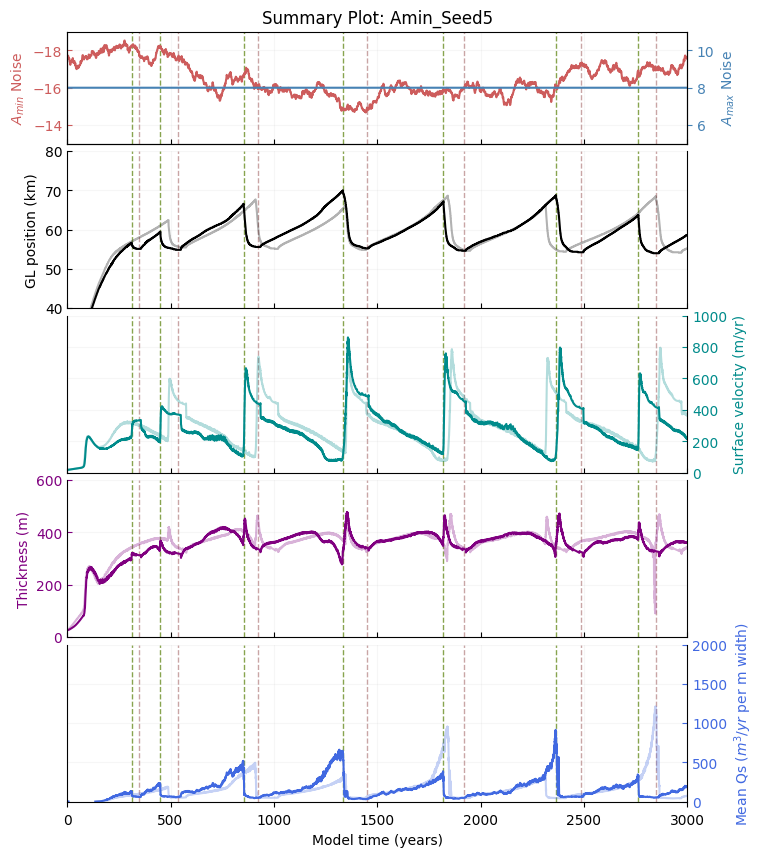

In [18]:
# Summary Plot with Mean Sediment Discharge
fig = plt.figure(figsize=(8, 10))
gs = GridSpec(5, 1, height_ratios=[1, 1.4, 1.4, 1.4, 1.4], hspace=0.05)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)
ax3 = fig.add_subplot(gs[3], sharex=ax0)
ax4 = fig.add_subplot(gs[4], sharex=ax0)

# === Climate noise ===
ax0.plot(time_years, noisy_amin_series, color='indianred')
ax0.set_ylim(-13,-19)

ax0r = ax0.twinx()
ax0r.plot(time_years, noisy_amax_series, color='steelblue')
ax0r.set_ylim(5,11, auto = False)

ax0.set_ylabel('$A_{min}$ Noise', color='indianred')
ax0.tick_params(axis='y', colors='indianred')
ax0r.set_ylabel('$A_{max}$ Noise', color='steelblue')
ax0r.tick_params(axis='y', colors='steelblue')

# === GL plot ===
ax1.plot(timeBase, GL_kmBase, color='black', alpha=0.3)
ax1.plot(timesteps_model, GL_Noisy_km, color='black')
ax1.set_ylabel('GL position (km)', color='black')
ax1.set_ylim(40, 80)
ax1.tick_params(axis='y', colors='black')

# === Velocity plot ===
ax2.plot(timeBase, term_surface_velocity_base, color='darkcyan', alpha=0.3)
ax2.plot(timesteps_model, term_surface_velocity, color='darkcyan')
ax2.set_ylabel('Surface velocity (m/yr)', color='darkcyan')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.set_ylim(0,1000)
ax2.tick_params(axis='y', colors='darkcyan')

# === Thickness plot ===
ax3.plot(timeBase, term_thickness_base, color='purple', alpha=0.3)
ax3.plot(timesteps_model, term_thickness, color='purple')
ax3.set_ylabel('Thickness (m)', color='purple')
ax3.tick_params(axis='y', colors='purple')
ax3.set_ylim(0, 600)

# === Qs plot ===
ax4.plot(timesteps_Qs_Base, mean_Qs_filtered_base, color='royalblue', alpha=0.3)
ax4.plot(timesteps_model, mean_Qs_filtered, color='royalblue')
ax4.set_ylabel('Mean Qs ($m^3/yr$ per m width)', color='royalblue')
ax4.yaxis.set_label_position('right')
ax4.yaxis.tick_right()
ax4.set_ylim(0,2000)
ax4.tick_params(axis='y', colors='royalblue')

for a in [ax0, ax1, ax2, ax3, ax4]:
    a.spines['top'].set_visible(False)
    a.grid(alpha=0.1)
    a.set_xlim(0, 3000)
    a.tick_params(direction='in')
    for t in peaktimes:
        a.axvline(x=t, color='olivedrab', lw=1, ls='--', alpha=0.8, zorder=0)
    for t in troughtimes:
        a.axvline(x=t, color='rosybrown', lw=1, ls='--', alpha=0.8, zorder=0)

for a in [ax0, ax1, ax2, ax3]:
    plt.setp(a.get_xticklabels(), visible=False)

ax0.set_title(f"Summary Plot: {runName}")
ax4.tick_params(axis='x', which='both', pad=5, direction='out')
ax4.set_xlabel('Model time (years)')

plt.show()

fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/SummaryPlots/{runName}_SummaryPlot_update.svg", format ="svg", bbox_inches='tight')
fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/SummaryPlots/{runName}_SummaryPlot_update.png", format ="png", bbox_inches='tight')


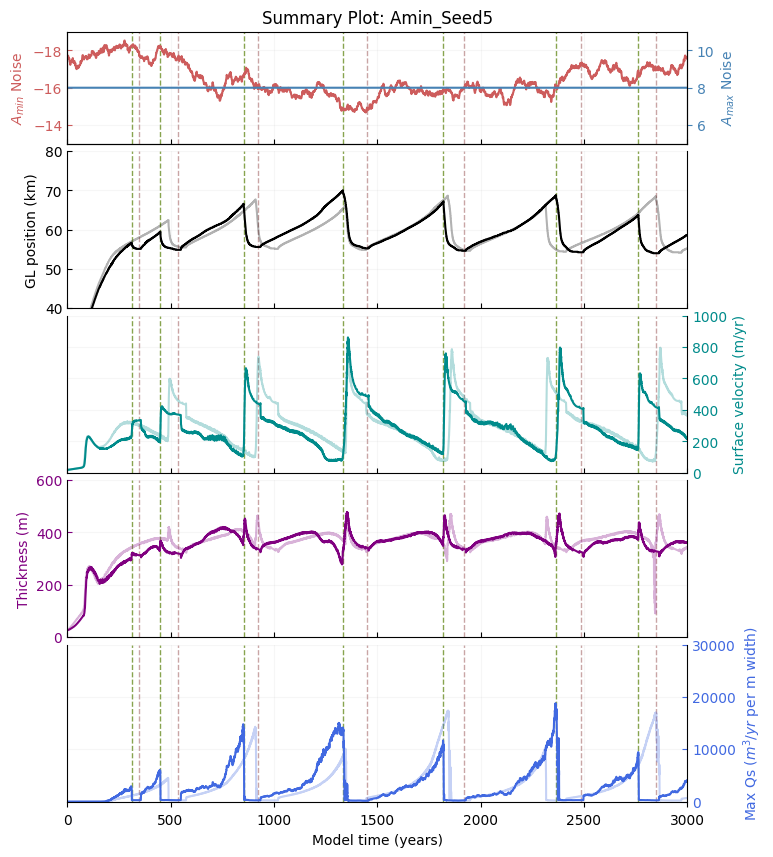

In [19]:
# Summary Plot with Max Sediment Discharge
fig = plt.figure(figsize=(8, 10))
gs = GridSpec(5, 1, height_ratios=[1, 1.4, 1.4, 1.4, 1.4], hspace=0.05)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)
ax3 = fig.add_subplot(gs[3], sharex=ax0)
ax4 = fig.add_subplot(gs[4], sharex=ax0)

# === Climate noise ===
ax0.plot(time_years, noisy_amin_series, color='indianred')
ax0.set_ylim(-13,-19)

ax0r = ax0.twinx()
ax0r.plot(time_years, noisy_amax_series, color='steelblue')
ax0r.set_ylim(5,11, auto = False)

ax0.set_ylabel('$A_{min}$ Noise', color='indianred')
ax0.tick_params(axis='y', colors='indianred')
ax0r.set_ylabel('$A_{max}$ Noise', color='steelblue')
ax0r.tick_params(axis='y', colors='steelblue')

# === GL plot ===
ax1.plot(timeBase, GL_kmBase, color='black', alpha=0.3)
ax1.plot(timesteps_model, GL_Noisy_km, color='black')
ax1.set_ylabel('GL position (km)', color='black')
ax1.set_ylim(40, 80)
ax1.tick_params(axis='y', colors='black')

# === Velocity plot ===
ax2.plot(timeBase, term_surface_velocity_base, color='darkcyan', alpha=0.3)
ax2.plot(timesteps_model, term_surface_velocity, color='darkcyan')
ax2.set_ylabel('Surface velocity (m/yr)', color='darkcyan')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.set_ylim(0,1000)
ax2.tick_params(axis='y', colors='darkcyan')

# === Thickness plot ===
ax3.plot(timeBase, term_thickness_base, color='purple', alpha=0.3)
ax3.plot(timesteps_model, term_thickness, color='purple')
ax3.set_ylabel('Thickness (m)', color='purple')
ax3.tick_params(axis='y', colors='purple')
ax3.set_ylim(0, 600)

# === Qs plot ===
ax4.plot(timesteps_Qs_Base, max_Qs_base, color='royalblue', alpha=0.3)
ax4.plot(timesteps_model, max_Qs, color='royalblue')
ax4.set_ylabel('Max Qs ($m^3/yr$ per m width)', color='royalblue')
ax4.yaxis.set_label_position('right')
ax4.yaxis.tick_right()
ax4.set_ylim(0,30000)
ax4.tick_params(axis='y', colors='royalblue')

for a in [ax0, ax1, ax2, ax3, ax4]:
    a.spines['top'].set_visible(False)
    a.grid(alpha=0.1)
    a.set_xlim(0, 3000)
    a.tick_params(direction='in')
    for t in peaktimes:
        a.axvline(x=t, color='olivedrab', lw=1, ls='--', alpha=0.8, zorder=0)
    for t in troughtimes:
        a.axvline(x=t, color='rosybrown', lw=1, ls='--', alpha=0.8, zorder=0)

for a in [ax0, ax1, ax2, ax3]:
    plt.setp(a.get_xticklabels(), visible=False)

ax0.set_title(f"Summary Plot: {runName}")
ax4.tick_params(axis='x', which='both', pad=5, direction='out')
ax4.set_xlabel('Model time (years)')

plt.show()

fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/SummaryPlots/{runName}_SummaryPlot_update_maxQs.svg", format ="svg", bbox_inches='tight')
fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/SummaryPlots/{runName}_SummaryPlot_update_maxQs.png", format ="png", bbox_inches='tight')


# Bedrock Change

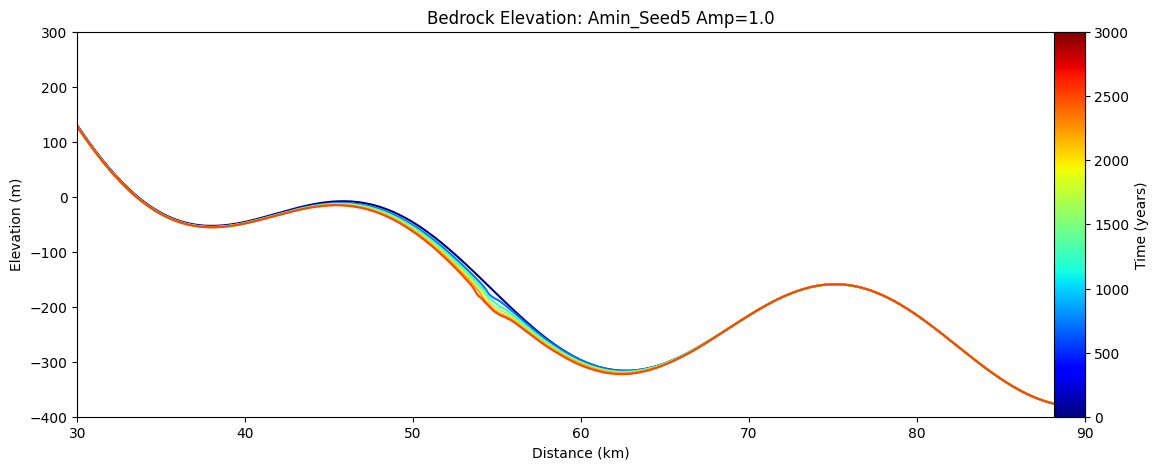

In [20]:
num_points = len(next(iter(bed_dict.values())))
x_km = mesh_index_to_km(np.arange(num_points))
timesteps_model = list(bed_dict.keys())
norm = plt.Normalize(min(timesteps_model), max(timesteps_model))
cmap = cm.jet

fig, ax1 = plt.subplots(figsize=(13,5))

for i, t in enumerate(timesteps_model):
    if i % 1000 != 0:  
        continue
    bed = bed_dict[t]
    color = cmap(norm(t))
    ax1.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

ax1.set_xlabel("Distance (km)")
ax1.set_ylabel("Elevation (m)")
ax1.set_xlim(30, 90)
ax1.set_ylim(-400, 300)

# Make ScalarMappable for colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbaxes = inset_axes(ax1, width="3%", height="100%", loc='upper right',
                    bbox_to_anchor=(0, 0, 1, 1),
                    bbox_transform=ax1.transAxes, borderpad=0.01)

cbar = plt.colorbar(sm, cax=cbaxes)
cbar.set_label('Time (years)')
plt.title(f"Bedrock Elevation: {runName} {NoiseAmp}", position=(-15, 1.05))
plt.show()

# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_BedErosion_{runName}_update.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_BedErosion_{runName}_update.png", format ="png", bbox_inches='tight')


# More Plots

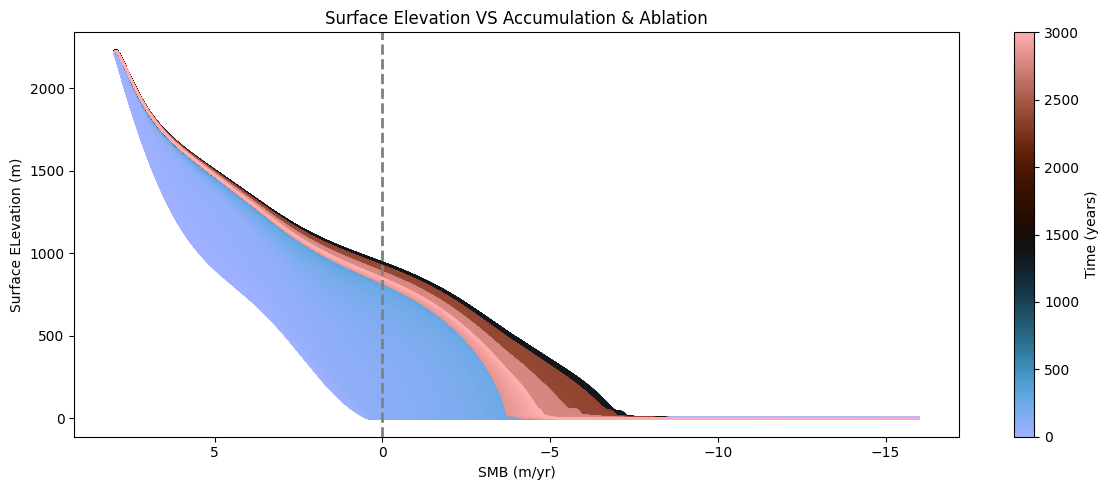

In [21]:
timesteps = sorted(SMB_dict.keys())
smb_profile = SMB_dict[timesteps[0]] 
cmap = cm.berlin

fig,ax  = plt.subplots(figsize=(12,5))


counts = sorted(counter_dict.values())  # all loop counts
sample_counts = counts[::1] 

# make a lookup: loop count → time
loop_to_time = {v: k for k, v in counter_dict.items()}

for j, c in enumerate(sample_counts):
    t = loop_to_time[c]
    surf = surf_dict[t]
    color = cmap(norm(t))
    label = f't={t:.1f}' if j % 5 == 0 else ""
    plt.plot(smb_profile, surf, color=color, label=label)


plt.xlabel("SMB (m/yr)")
plt.ylabel("Surface ELevation (m)")
plt.title("Surface Elevation VS Accumulation & Ablation")
plt.gca().invert_xaxis()
# plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, label='Time (years)', ax=plt.gca())
plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/SMB_plot_40k_default.svg", format ="svg", bbox_inches='tight')

final_smb = list(SMB_dict.values())[-1]
# print(final_smb)

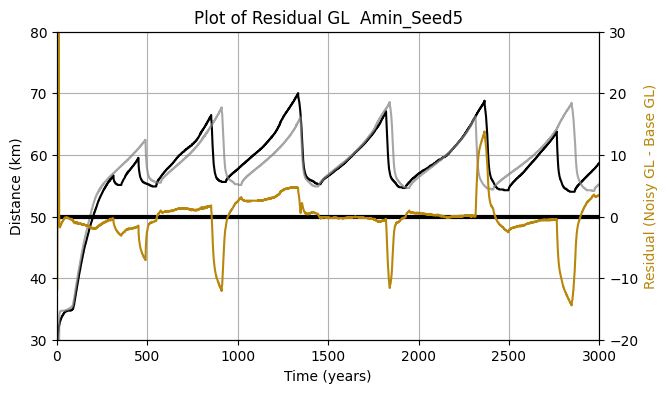

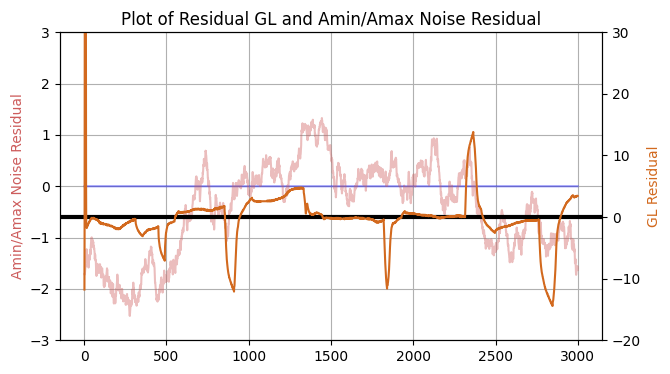

In [22]:
fig, ax = plt.subplots(figsize = (7,4))

# Grounding Line 
ax.plot(time_years, gl_noisy_interp_yrs, color = 'black', label = 'GL (with Climate Noise)')
ax.plot(time_years, gl_base_interp_yrs, color = 'gray', label = 'Base Run', alpha = 0.7)

# Residual of Base & Noisy GL
ax2 = ax.twinx()
ax2.axhline(y=0, linewidth = 3, color = 'black')
ax2.plot(time_years, GL_resid, color = 'darkgoldenrod', label = 'GL residual')

ax.set_xlim(0,3000)
ax.set_ylim(30,80)
ax2.set_ylim(-20,30)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Distance (km)")
ax2.set_ylabel("Residual (Noisy GL - Base GL)", color = 'darkgoldenrod')

ax.grid()
plt.title(f"Plot of Residual GL  {runName}")

# Plot of Residual Climate Noise
fig, ax = plt.subplots(figsize = (7,4))

# AMAX Noise Residual
ax.plot(time_years, amax_noise_resid, color = 'blue', alpha = 0.4)
ax.set_ylabel("Amax Noise Residual", color = 'blue')
plt.title(f"Plot of Residual GL and Amax Residual {runName}")

# AMIN Noise Residual
ax.plot(time_years, amin_noise_resid, color = 'indianred', alpha = 0.4)
ax.set_ylabel("Amin/Amax Noise Residual", color = 'indianred')
plt.title("Plot of Residual GL and Amin/Amax Noise Residual")

ax2 = ax.twinx()
ax2.axhline(y=0, linewidth = 3, color = 'black')
ax2.plot(time_years, GL_resid, color = 'chocolate', label = 'GL residual')
ax2.set_ylabel("GL Residual", color = 'chocolate')
ax.set_ylim(-3,3)
ax2.set_ylim(-20,30)
ax.grid()


In [23]:
def find_lag_scipy(x, y, dt=1.0):
    x = x - np.mean(x)
    y = y - np.mean(y)
    corr = correlate(x, y, mode='same', method='fft')
    lags = correlation_lags(len(x), len(y), mode='same') * dt
    lag = lags[np.argmax(corr)]
    return lag, corr, lags

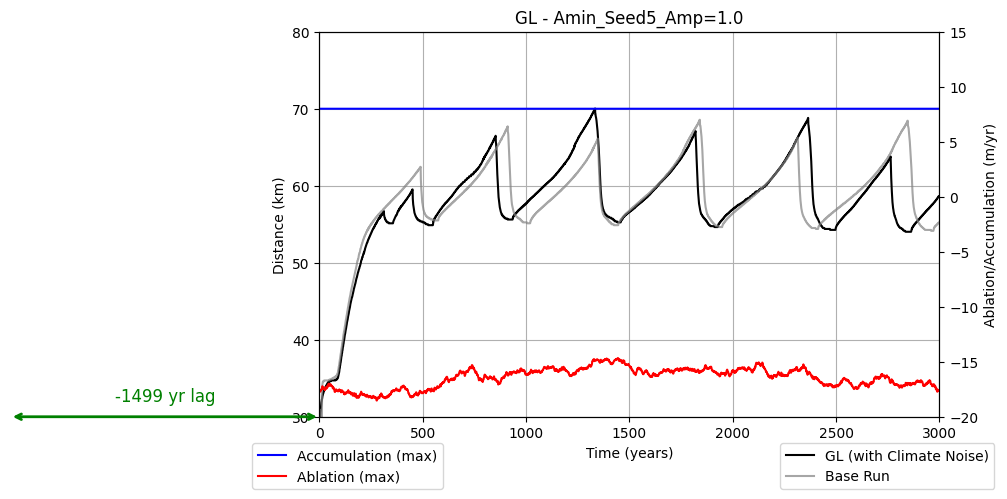

In [24]:
fig, ax = plt.subplots(figsize = (8,5))

# AMAX Lag Calculation
lag_resid_amax, corr_resid_amax, lags_resid_amax = find_lag_scipy(GL_resid, amax_noise_resid, dt=1.0)
t_peak = time_years[np.argmax(noisy_amax_series)]

# AMIN Lag Calculation
# lag_resid_amin, corr_resid_amin, lags_resid_amin = find_lag_scipy(GL_resid, amin_noise_resid, dt=1.0)
# t_peak = time_years[np.argmax(noisy_amin_series)]

# Grounding Line 
ax.plot(time_years, gl_noisy_interp_yrs, color = 'black', label = 'GL (with Climate Noise)')
ax.plot(time_years, gl_base_interp_yrs, color = 'gray', label = 'Base Run', alpha = 0.7)

# Interpolated Noisy Accumulation and Abaltion 
ax2 = ax.twinx()
ax2.plot(time_years, noisy_amax_series, label = 'Accumulation (max)', color = 'blue')
ax2.plot(time_years, noisy_amin_series, label = 'Ablation (max)', color = 'red')

# AMAX Lag Arrow
ax.annotate('', 
            xy=(t_peak, 30), 
            xytext=(t_peak + lag_resid_amax, 30), 
            arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax.text(t_peak + lag_resid_amax/2, 32, f"{lag_resid_amax:.0f} yr lag", color='green', ha='center', fontsize = 12)

# AMIN Lag Arrow
# ax.annotate('', 
#             xy=(t_peak, 30), 
#             xytext=(t_peak + lag_resid_amin, 30), 
#             arrowprops=dict(arrowstyle='<->', color='green', lw=2))
# ax.text(t_peak + lag_resid_amin/2, 32, f"{lag_resid_amin:.0f} yr lag", color='green', ha='center', fontsize = 12)

ax.legend(bbox_to_anchor=(1.1, -0.05))
ax2.legend(bbox_to_anchor=(.21, -0.05))

ax.set_xlim(0,3000)
ax.set_ylim(30,80)
ax2.set_ylim(-20,15)

ax.set_xlabel("Time (years)")
ax.set_ylabel("Distance (km)")
ax2.set_ylabel("Ablation/Accumulation (m/yr)")

plt.title(f"GL - {runName}_{NoiseAmp}")
ax.grid()
plt.show()

In [25]:
def find_lag_phys(x, y, dt=1.0, max_lag=500):
    """
    Returns a physically meaningful lag (years) by:
      - detrending mean
      - computing full cross-correlation
      - returning the strongest peak within ±max_lag years around zero
    """
    # detrend & mean-center
    x2 = detrend(x - np.mean(x))
    y2 = detrend(y - np.mean(y))

    corr = correlate(x2, y2, mode='full', method='fft')
    lags = correlation_lags(len(x2), len(y2), mode='full') * dt

    # plot optionally to inspect - caller can do this
    # pick near-zero peak
    mask = np.abs(lags) <= max_lag
    if not np.any(mask):
        raise ValueError("max_lag too small.")
    lag_near0 = lags[mask][np.argmax(corr[mask])]
    return lag_near0, corr, lags

lag = -1499.0 years


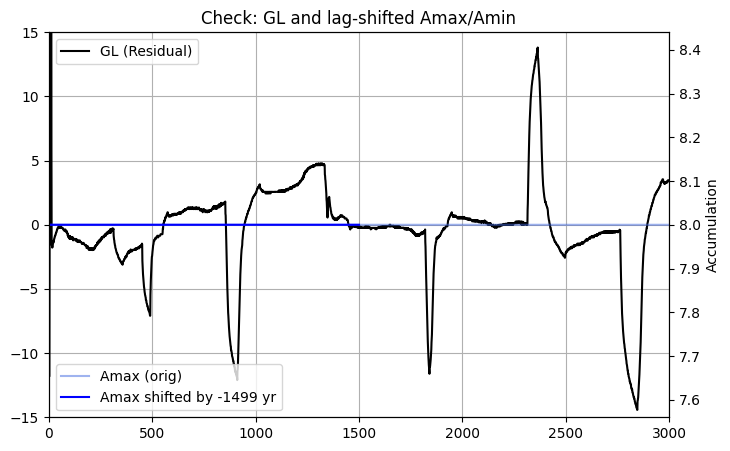

In [26]:
dt = np.mean(np.diff(time_years))

fig, ax = plt.subplots(figsize = (8,5))
# GL Plot
ax.plot(time_years, GL_resid, 'k', label='GL (Residual)')

ax2 = ax.twinx()

# AMAX
lag_resid_amax, corr_resid_amax, lags_resid_amax = find_lag_scipy(GL_resid, amax_noise_resid, dt=dt)
print(f"lag = {lag_resid_amax:.1f} years")
ax2.plot(time_years, noisy_amax_series, 'royalblue', alpha=0.5, label='Amax (orig)')
ax2.plot(time_years + lag_resid_amax, noisy_amax_series, 'b', alpha=1, label=f'Amax shifted by {lag_resid_amax:.0f} yr')
ax2.set_ylabel("Accumulation")


# AMIN
# lag_resid_amin, corr_resid_amin, lags_resid_amin = find_lag_phys(GL_resid, amin_noise_resid, dt=dt, max_lag=600)
# print(f"lag = {lag_resid_amin:.1f} years")
# ax2.plot(time_years, noisy_amin_series, 'red', alpha=0.4, label='Amin (orig)')
# ax2.plot(time_years + lag_resid_amin, noisy_amin_series, 'red', alpha=1, label=f'Amin shifted by {lag_resid_amin:.0f} yr')
# ax2.set_ylabel("Ablation")

ax.set_xlim(0, 3000)
ax.set_ylim(-15, 15)
ax.legend()
ax2.legend(loc = 3)
ax.grid()
plt.title('Check: GL and lag-shifted Amax/Amin')
plt.show()



# Cross Correlation Plot
# plt.figure(figsize=(5,2))

# # AMAX
# plt.plot(lags_resid_amax, corr_resid_amax)
# plt.axvline(lag_resid_amax, color='orange', linestyle='--')

# # AMIN
# # plt.plot(lags_resid_amin, corr_resid_amin)
# # plt.axvline(lag_resid_amin, color='orange', linestyle='--')

# plt.axvline(0, color='k', linestyle='--', linewidth=0.8)
# plt.xlim(-800, 800)
# plt.xlabel('Lag (years)')
# plt.ylabel('Cross-correlation')
# plt.title('Cross-correlation (detrended)')
# plt.show()

# Power Spectrum

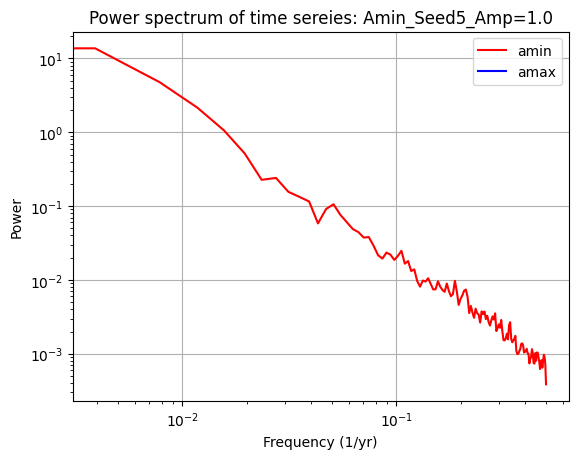

In [27]:
plt.figure()
plt.loglog(freqs_amin1, Pxx_amin1, color = 'red', label = 'amin')
plt.loglog(freqs_amax1, Pxx_amax1, color = 'blue', label = 'amax')
plt.xlabel("Frequency (1/yr)")
plt.ylabel("Power")
plt.title(f"Power spectrum of time sereies: {runName}_{NoiseAmp}")
plt.legend()
plt.grid(True)
plt.show()

# Amin & Amax Over Time

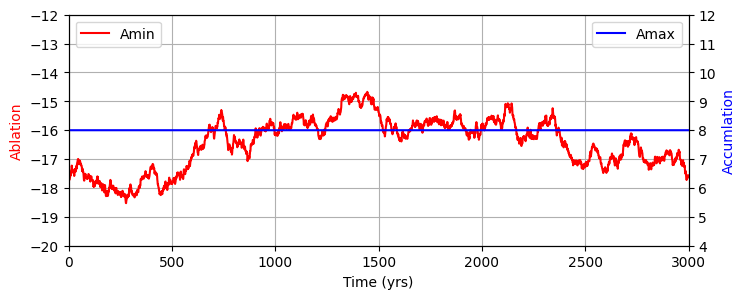

In [28]:
fig, ax = plt.subplots(figsize = (8,3))

ax.plot(time_years, noisy_amin_series, color = 'red', label = "Amin")
ax.set_ylabel("Ablation", color = 'red')
ax2 = ax.twinx()
ax2.plot(time_years, noisy_amax_series, color = 'blue', label = 'Amax')
ax2.set_ylabel("Accumlation", color = 'blue')
ax.set_xlabel("Time (yrs)")
ax.legend(loc=2)
ax2.legend(loc=1)


# ax.plot(timesteps2, amin_series2, color = 'red')
# ax2 = ax.twinx()
# ax2.plot(timesteps2, amax_series2, color = 'blue')
ax.set_ylim(-20,-12)
ax2.set_ylim(4,12)
ax.set_xlim(0,3000)
ax.grid()
plt.show()


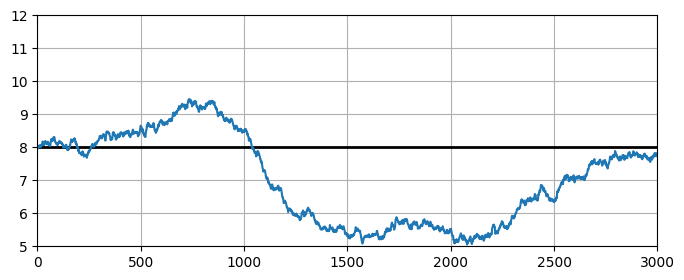

In [29]:
# Testing random number generator noise options
rand = np.random.default_rng(148)
beta = 2
t_end = 10000

noise = cn.powerlaw_psd_gaussian(beta, t_end, random_state=rand)


noise += 8  # mean offset

fig, ax = plt.subplots(figsize = (8,3))

ax.axhline(y=8, color = 'black', linewidth = 2)
ax.plot(noise)
ax.set_xlim(0,3000)
ax.set_ylim(5,12)
ax.grid()

# Random Tests

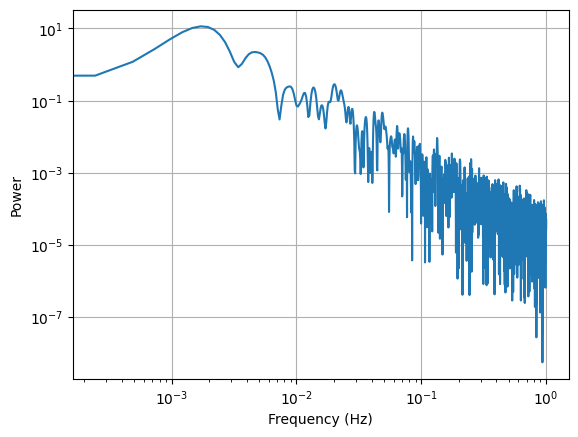

standard dev: 0.7723916756217338
mean: 0.0006784253913261438


In [30]:
rand = np.random.default_rng(7)
beta = 2 # the exponent
samples = 2000 # number of samples to generate
y = cn.powerlaw_psd_gaussian(beta, samples, random_state=rand)

# y *= 1.0

s, f = mlab.psd(y, NFFT=2**13)
plt.loglog(f,s)
plt.grid(True)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

print(f"standard dev: {np.std(y)}")
print(f"mean: {np.mean(y)}")